In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.preprocessing import image

from sklearn.model_selection import train_test_split

2023-10-18 15:19:40.763570: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-18 15:19:40.763619: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-18 15:19:40.763649: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-18 15:19:40.770750: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_dir = 'DataL2'
image_files = os.listdir(data_dir)

# Paramètres des images
img_height, img_width, rgb = 128, 128, 3
input_img = Input(shape=(img_height, img_width, rgb))
images = []

for img_file in image_files:
    img_path = os.path.join(data_dir, img_file)
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    images.append(img_array)

images = np.array(images)

print("Chargement terminé.")

Chargement terminé.


In [3]:
# Afficher quelques informations de base sur les données
print(f"Nombre total d'images : {images.shape[0]}")
print(f"Dimensions des images : {images.shape[1:]}")
print(f"Valeur min des pixels : {np.min(images)}")
print(f"Valeur max des pixels : {np.max(images)}")

Nombre total d'images : 148
Dimensions des images : (128, 128, 3)
Valeur min des pixels : 0.0
Valeur max des pixels : 255.0


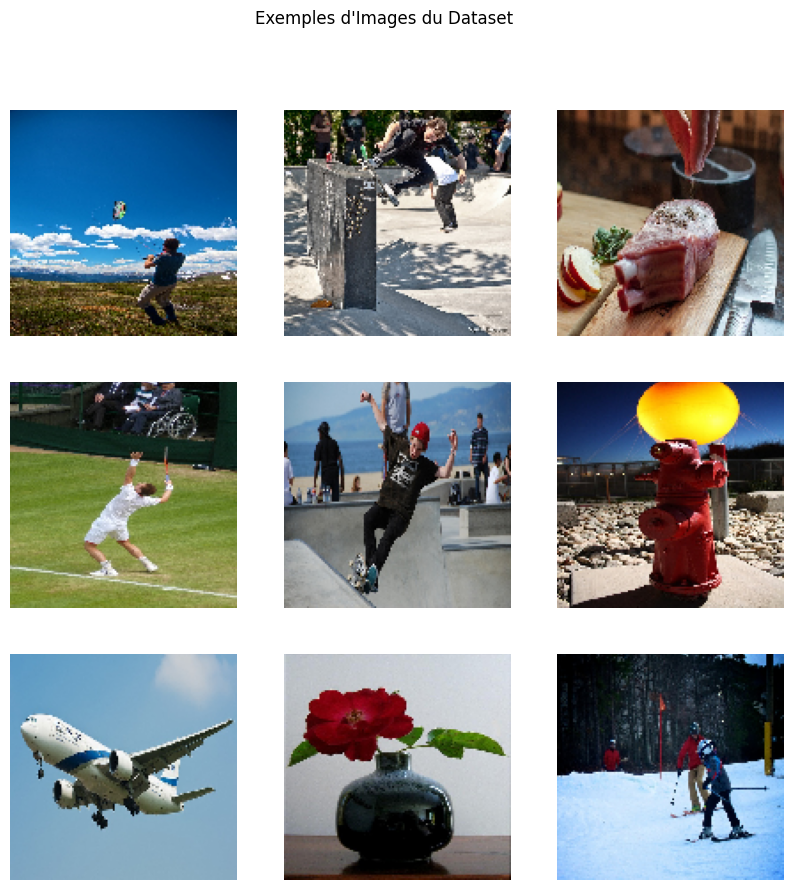

In [4]:
# Afficher quelques images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].astype('uint8'))
    plt.axis('off')
plt.suptitle('Exemples d\'Images du Dataset')
plt.show()

In [5]:
# Normaliser les images pour que les valeurs de pixel soient dans [0, 1]
normalized_images = images / 255.0

print("Normalisation terminé.")

Normalisation terminé.


In [6]:
# Paramètres pour l'ajout de bruit
noise_factor_015 = 0.15
noise_factor_040 = 0.40

# Ajout d'un bruit gaussien léger aux images
noisy_images_015 = normalized_images + noise_factor_015 * np.random.normal(loc=0.0, scale=1.0, size=normalized_images.shape)
noisy_images_015 = np.clip(noisy_images_015, 0., 1.)

# Ajout d'un bruit gaussien fort aux images
noisy_images_040 = normalized_images + noise_factor_040 * np.random.normal(loc=0.0, scale=1.0, size=normalized_images.shape)
noisy_images_040 = np.clip(noisy_images_040, 0., 1.)

print("Bruitage terminé.")

Bruitage terminé.


In [7]:
# Diviser les données en ensembles d'entraînement et de test
X_train_015, X_test_015, y_train_015, y_test_015 = train_test_split(
    noisy_images_015,   # Entrée (images bruitées)
    normalized_images,  # Cibles (images originales)
    test_size=0.2,
    random_state=42
)

# Diviser les données en ensembles d'entraînement et de test
X_train_040, X_test_040, y_train_040, y_test_040 = train_test_split(
    noisy_images_040,   # Entrée (images bruitées)
    normalized_images,  # Cibles (images originales)
    test_size=0.2,
    random_state=42
)

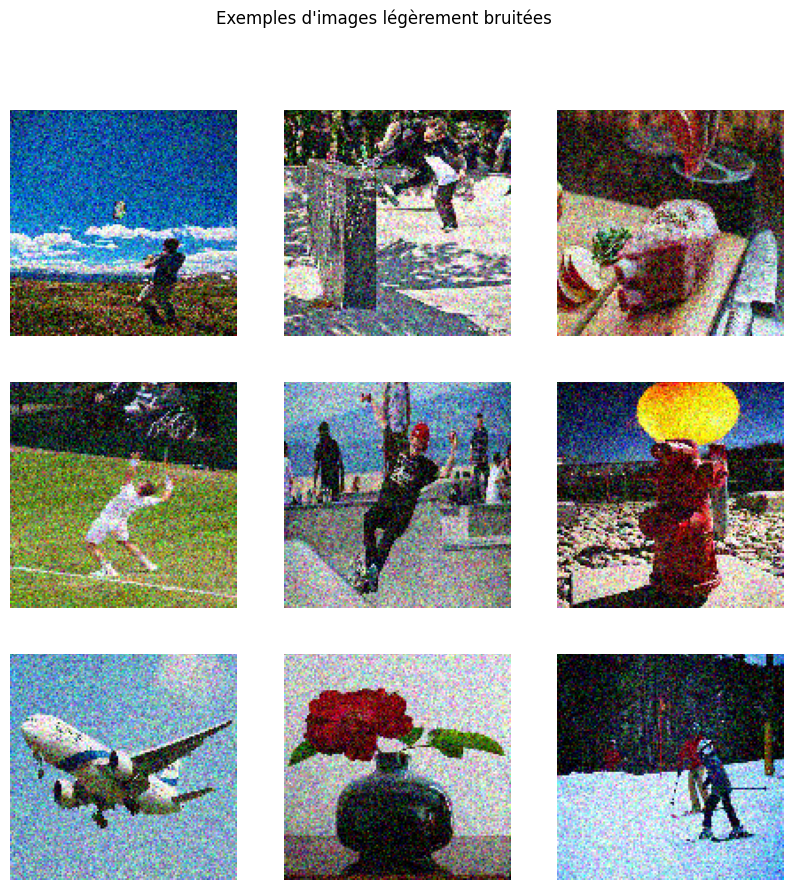

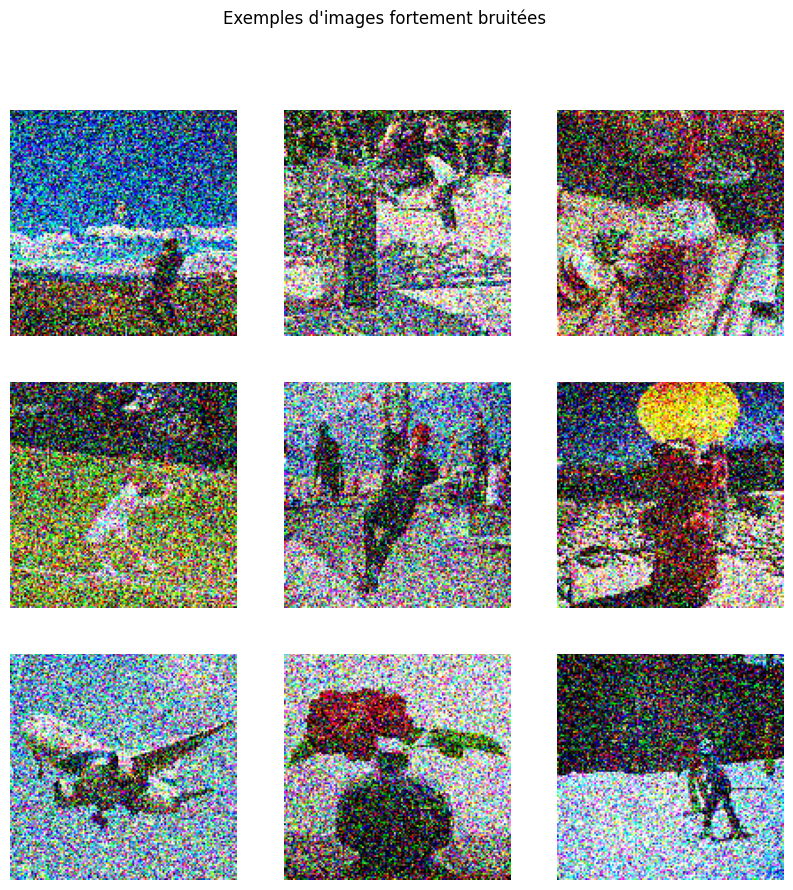

In [8]:
# Afficher quelques images légèrement bruitées
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(noisy_images_015[i].astype('float32'))
    plt.axis('off')
plt.suptitle('Exemples d\'images légèrement bruitées')
plt.show()

# Afficher quelques images fortement bruitées
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(noisy_images_040[i].astype('float32'))
    plt.axis('off')
plt.suptitle('Exemples d\'images fortement bruitées')
plt.show()

In [9]:
# Coding the specific sampling layer as a Keras Layer object
class Sampling(layers.Layer):

    def call(self, inputs):
        z_mean, z_logvar = inputs

        nbatch = K.shape(z_mean)[0]
        ndim = K.shape(z_mean)[1]

        std = K.exp(z_logvar)
        eps = K.random_normal(shape=(nbatch,ndim), mean=0., stddev=0.1)

        z = z_mean + eps * std

        return z

In [10]:
cara = img_width * img_height
cara

16384

In [11]:
encoder_inputs = keras.Input(shape=(img_height, img_width, rgb))

x = layers.Flatten()(encoder_inputs)  # Flatten the RGB image
x = layers.Dense(2000, activation="relu")(x)

z_mean = layers.Dense(100)(x)
z_logvar = layers.Dense(100)(x)

z = Sampling()([z_mean, z_logvar])

encoder = keras.Model(encoder_inputs, z, name="encoder")


2023-10-18 15:19:45.078943: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-18 15:19:45.082930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-18 15:19:45.082970: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-18 15:19:45.084101: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-18 15:19:45.084170: I tensorflow/compile

In [12]:
# Decoder architecture
decoder_inputs = keras.Input(shape=(100,))
x = layers.Dense(200, activation="relu")(decoder_inputs)
x = layers.Dense(img_height * img_width * rgb, activation="sigmoid")(x)
decoder_outputs = layers.Reshape((img_height, img_width, rgb))(x)
decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")


In [13]:
# Combining architectures
outputs = decoder(z)
vae = keras.Model(encoder_inputs, outputs, name="vae")

In [14]:
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 flatten (Flatten)           (None, 49152)                0         ['input_2[0][0]']             
                                                                                                  
 dense (Dense)               (None, 2000)                 9830600   ['flatten[0][0]']             
                                                          0                                       
                                                                                                  
 dense_1 (Dense)             (None, 100)                  200100    ['dense[0][0]']             

In [15]:
# Compiling the model
vae.compile(optimizer='adam', loss='binary_crossentropy' )

In [16]:
# Fitting the model
history = vae.fit(X_train_015, X_train_015,
                  epochs=30,
                  batch_size=128,
                  shuffle=True,
                  validation_data=(X_test_015, X_test_015))

Epoch 1/30


2023-10-18 15:20:01.133289: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5f6c3c21e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-18 15:20:01.133353: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro P4000, Compute Capability 6.1
2023-10-18 15:20:01.140164: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-18 15:20:01.671379: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-10-18 15:20:01.762489: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 11s 11s/step - loss: 0.6933 - val_loss: 0.9391
Epoch 2/30
1/1 [==============================] - 1s 1s/step - loss: 0.8825 - val_loss: 7.6709
Epoch 3/30
1/1 [==============================] - 1s 1s/step - loss: 7.6644 - val_loss: nan
Epoch 4/30
1/1 [==============================] - 1s 1s/step - loss: nan - val_loss: nan
Epoch 5/30
1/1 [==============================] - 1s 1s/step - loss: nan - val_loss: nan
Epoch 6/30
1/1 [==============================] - 1s 1s/step - loss: nan - val_loss: nan
Epoch 7/30
1/1 [==============================] - 1s 1s/step - loss: nan - val_loss: nan
Epoch 8/30
1/1 [==============================] - 1s 1s/step - loss: nan - val_loss: nan
Epoch 9/30
1/1 [==============================] - 1s 1s/step - loss: nan - val_loss: nan
Epoch 10/30
1/1 [==============================] - 1s 1s/step - loss: nan - val_loss: nan
Epoch 11/30
1/1 [==============================] - 1s 1s/step - loss: nan - val_loss: nan
Epoch 12/30
1

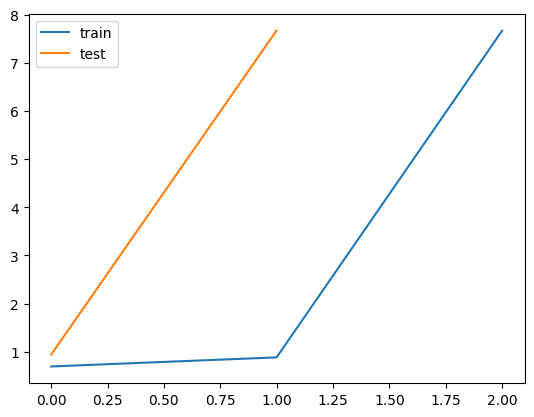

In [17]:
# Visualizing the training and validation losses
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

ValueError: cannot reshape array of size 49152 into shape (1,16384)

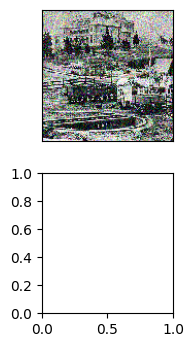

In [18]:
n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test_015[i].reshape(128, 128, 3), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    encoded_img = encoder.predict(np.array([X_test_015[i]]).reshape(1,cara))
    decoded_img = decoder.predict(encoded_img).reshape(128, 128, 3)
    plt.imshow(decoded_img, cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()